In [18]:
from processador_ibovespa import ProcessadorIbovespa
import pandas as pd

caminho_arquivo = "../../dados/investimento/ibovespa.csv"
processador = ProcessadorIbovespa(caminho_arquivo)
features_desejadas = ['dias_semana', 'lags', 'diffs', 'volatilidade', 'medias_moveis', 'nulos_tratados']

df_final = processador.get_dataframe(features=features_desejadas)
df_final.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%,Variacao_Diaria_Pontos,Amplitude_Diaria,Volume_Normalizado,...,Dia_4,lag_1,lag_2,lag_3,diff_1,diff_2,diff_3,Volatilidade_5d,Media_Movel_5d,Media_Movel_20d
4998,2000-12-27,15.186,14.805,15.223,14.805,239980000.0,2.65,0.381,0.418,0.241110,...,False,52.319932,52.307833,52.296019,0.019968,0.039487,0.058691,0.245976,52.322903,52.285099
4997,2000-12-28,15.259,15.188,15.269,15.132,324260000.0,0.48,0.071,0.137,0.325827,...,False,15.186000,52.307833,52.296019,0.073000,0.039487,0.058691,0.245976,52.322903,52.285099
4996,2001-01-02,15.425,15.242,15.621,15.174,230630000.0,1.09,0.183,0.447,0.231712,...,False,15.259000,15.186000,52.296019,0.166000,0.239000,0.058691,0.245976,52.322903,52.285099
4995,2001-01-03,16.599,15.425,16.599,15.251,381200000.0,7.61,1.174,1.348,0.383061,...,False,15.425000,15.259000,15.186000,1.174000,1.340000,1.413000,0.245976,52.322903,52.285099
4994,2001-01-04,16.675,16.597,16.933,16.587,331230000.0,0.46,0.078,0.346,0.332833,...,False,16.599000,15.425000,15.259000,0.076000,1.250000,1.416000,0.245976,15.828800,52.285099


In [19]:
from sklearn.model_selection import train_test_split

# Supondo que a coluna de data seja chamada 'Data'
df_final['Ano'] = df_final['Data'].dt.year
df_final['Mes'] = df_final['Data'].dt.month
df_final['Dia'] = df_final['Data'].dt.day
# Pode adicionar mais componentes como hora, minuto se forem relevantes

# Removendo a coluna de data original
df_final.drop('Data', axis=1, inplace=True)

# Atualizando X_train e y_train
X = df_final.drop('Último', axis=1)  # Ou outra coluna target que você esteja usando
y = df_final['Último']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [20]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [21]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, R²: {r2}")


MSE: 0.20757642923689887, R²: 0.9996975502610081


1. Validação Cruzada
A validação cruzada é uma técnica poderosa para avaliar a generalização do modelo. Ela envolve dividir o conjunto de dados em várias partes e treinar/testar o modelo em diferentes combinações dessas partes.

In [24]:
from sklearn.model_selection import cross_val_score

# Utilizando validação cruzada com 5 divisões
scores = cross_val_score(RandomForestRegressor(random_state=42), X, y, cv=5, scoring='neg_mean_squared_error')

# Convertendo scores em positivo e calculando a média e o desvio padrão
mse_scores = -scores
print("MSE médio: ", mse_scores.mean())
print("Desvio padrão do MSE: ", mse_scores.std())


MSE médio:  128.78941659164983
Desvio padrão do MSE:  208.21005634807042


2. Análise de Resíduos
A análise de resíduos pode ajudar a identificar padrões nos erros do modelo. Resíduos são basicamente as diferenças entre os valores reais e os previstos. Um bom modelo terá resíduos distribuídos aleatoriamente, sem padrões discerníveis

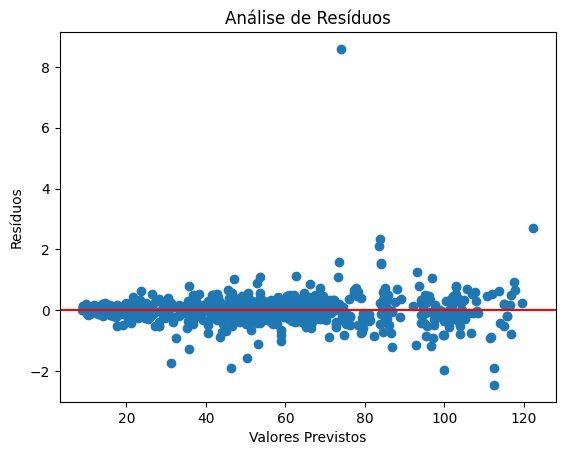

In [25]:
y_pred = model.predict(X_test)
residuos = y_test - y_pred

plt.scatter(y_pred, residuos)
plt.title('Análise de Resíduos')
plt.xlabel('Valores Previstos')
plt.ylabel('Resíduos')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


3. Comparação com um Modelo Simples (Baseline)
Compare o desempenho do seu modelo com um modelo mais simples, como uma regressão linear ou mesmo um modelo que sempre prevê a média dos valores alvo.

In [26]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy="mean")
dummy_regressor.fit(X_train, y_train)
dummy_score = dummy_regressor.score(X_test, y_test)  # R² score

print("Dummy R² score:", dummy_score)
print("Modelo R² score:", r2)  # O seu modelo R²


Dummy R² score: -0.0014992906078941104
Modelo R² score: 0.9996975502610081


4. Análise da Importância das Features
Use a importância das features para entender o papel de cada uma no modelo. Isso pode ajudar a identificar se o modelo está se baseando excessivamente em uma ou poucas features, o que pode ser um sinal de overfitting.

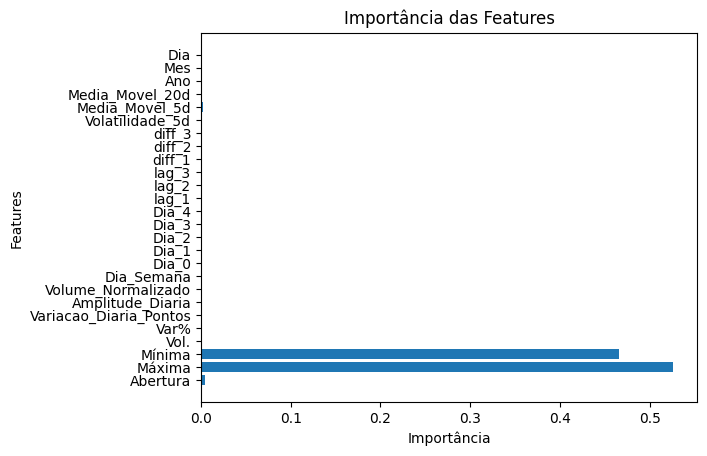

In [27]:
importances = model.feature_importances_
plt.barh(X.columns, importances)
plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.show()


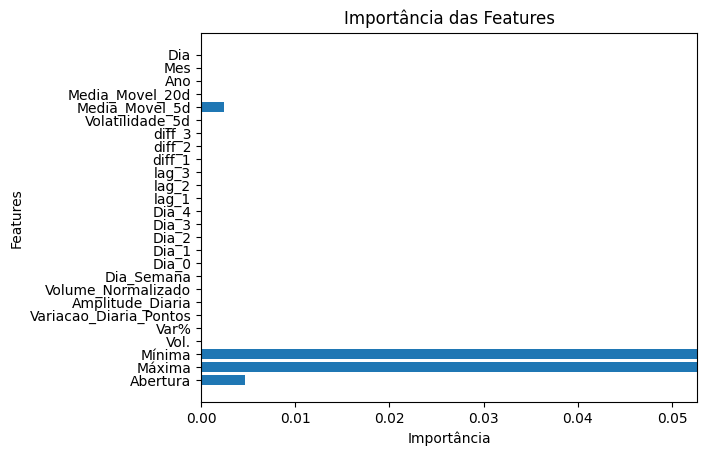

In [28]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
features = X.columns

# Criando o gráfico de barras horizontal
plt.barh(features, importances)

# Ajustando os limites do eixo x para focar nas importâncias menores
plt.xlim(0, max(importances) * 0.1)  # Ajuste este valor conforme necessário

plt.xlabel('Importância')
plt.ylabel('Features')
plt.title('Importância das Features')
plt.show()


In [29]:
import pandas as pd

# Criando um DataFrame com features e suas importâncias
feature_importances_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
})

# Filtrando para mostrar apenas features com importância maior que zero
features_maior_que_zero = feature_importances_df[feature_importances_df['Importance'] > 0]

# Exibindo a tabela
features_maior_que_zero


,Feature,Importance
0,Abertura,4.650618e-03
1,Máxima,5.264704e-01
2,Mínima,4.660730e-01
3,Vol.,4.784134e-06
4,Var%,3.821641e-05
5,Variacao_Diaria_Pontos,4.503684e-05
6,Amplitude_Diaria,9.687148e-06
7,Volume_Normalizado,5.472005e-06
8,Dia_Semana,2.629503e-06
9,Dia_0,5.383084e-07
